# Predict the Stock Market
The goal is to build a model that can predict the next n-day prices for individual stocks. It should minimise the loss on three metrics: directional accuracy, MAE and RMSE. The main evaluation method is the walk-forward evaluation, so it is critical to avoid data leakage.

The typical machine learning workflow is:

- Collect data
- Perform some EDA
- Clean / wrangle it
- Conduct feature selection and engineering
- Split the data for test/train/validation
- Train the model
- Evaluate the model
- Recycle the last two steps - tune hyperparameters, etc.

For us that means:

- Extract data from the yfinance package (yahoo finance)
- Analyse the raw outputs; volume, close price, trends, distributions, correlations
- Reshape the data to one observation per (date, ticker) and review the data coverage
- Explore ways to turn raw data into features e.g. lagged values, ranges, summary statistics
- Assess how to split the data in a time-appropriate way to avoid data leakage / 'snooping'
- Create a benchmark with the existing ridge regression, then explore SVMs, GBMs, LSTMs and potentially transformers to train the models
  - Need to explore the correct cost function to train on
- Assess the metrics for directional accuracy, MAE and RMSE
- Iterate testing for hyperparameter selection (e.g. leaf size for GBMs) and feature selection
- Test against the walk-forward evaluation

Throughout the process I need to keep reproducibility in mind, so test in Colab and Jupyter, test on Mac Mini and Windows laptop. Clear documentation as I go along would be heplful too...

Here is the existing Python package we'll be building on top of for the evaluation:





In [1]:
# @title
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


class Student:
    """
    Minimal baseline that predicts next-H-day cumulative log return from OHLCV.
    (1) Student responsibilities: data/feature engineering + model selection.
    (2) Tester provides the target y (log(C_{t+H}/C_t)) and walk-forward protocol.

    SCoursework essentials:
      (1) Data preprocessing (causal) from OHLCV
      (2) Feature engineering (simple technical indicators)
      (3) Model selection (small, time-aware CV for Ridge alpha)

    API expected by the tester:
      (1) fit(X_train: pd.DataFrame, y_train: pd.Series, meta: dict|None) -> self
      (2) predict(X: pd.DataFrame, meta: dict|None) -> pd.Series named 'y_pred'
    """

    def __init__(
        # This is called the object's 'state' in OOP - the attributes set here.
        # These are the default settings for the hyperparameters
        # that we can update when we initialise the Student() class
        # and this can be achieved either through a dictionary like this:
        # Student(config= {n_lags : 10, vol_windows: 30}) or in the args itself:
        # Student(n_lags=10, vol_windows=30).
        # If you want to e.g. choose a different model type, you need a dict
        # because the alpha_grid parameter is specific to Ridge (alpha)
        self,
        config=None,               # accepts None or dict of overrides
        random_state: int = 42,
        *,
        # feature knobs
        n_lags=10,                 # r_{t-1} ... r_{t-n}
        mom_windows=(10, 20, 60),  # mean of daily log-returns
        vol_window=30,             # std of daily log-returns
        sma_windows=(10, 20, 50, 200),
        ema_windows=(12, 26),
        rsi_window=14,
        # model selection knobs
        alpha_grid=(0.01, 0.1, 1.0, 10.0),
        cv_splits=3,
        min_train_points=200,
        # This is where you can add in additional hyperparameters
        **kwargs                   # tolerate extra kwargs from caller

    ):
        # defaults
        self.n_lags = int(n_lags)
        self.mom_windows = tuple(int(w) for w in mom_windows)
        self.vol_window = int(vol_window)
        self.sma_windows = tuple(int(w) for w in sma_windows)
        self.ema_windows = tuple(int(w) for w in ema_windows)
        self.rsi_window = int(rsi_window)

        self.alpha_grid = tuple(float(a) for a in alpha_grid)
        self.cv_splits = int(cv_splits)
        self.min_train_points = int(min_train_points)
        self.random_state = int(random_state)

        # overrides
        # This is where they check to see if the hyperparameters in the supplied
        # dict or function args match the existing ones and update the defaults
        if isinstance(config, dict):
            for k, v in config.items():
                if hasattr(self, k):
                    setattr(self, k, v)
        for k, v in kwargs.items():
            if hasattr(self, k):
                setattr(self, k, v)

        # learned state
        self.pipe_ = None
        self.best_alpha_ = None
        self.fitted_ = False

    # ---------- helpers ----------

    # Static methods are functions that live inside a class but don't need
    # access to the objects specific data, i.e. it's a regular function but
    # it is grouped within the class for organization. In this case they
    # serve as internal tools for later in the pipeline, and they aren't
    # used by us
    @staticmethod
    def _close_series(X: pd.DataFrame) -> pd.Series:
        return X["Close"] if "Close" in X.columns else X.iloc[:, 0]

    @staticmethod
    def _log_returns(series: pd.Series) -> pd.Series:
        series = pd.Series(series).astype(float)
        return np.log(series / series.shift(1))

    @staticmethod
    def _rsi(close: pd.Series, window: int) -> pd.Series:
        """RSI in [0,1] using Wilder’s smoothing (causal)."""
        close = pd.Series(close).astype(float)
        diff = close.diff()
        gain = diff.clip(lower=0.0)
        loss = -diff.clip(upper=0.0)
        avg_gain = gain.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
        avg_loss = loss.ewm(alpha=1/window, adjust=False, min_periods=window).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        rsi = 1 - (1 / (1 + rs))  # 0..1
        return rsi.fillna(0.5)

    @staticmethod
    def _finite_mean(y: pd.Series) -> float:
        """Return finite mean of y or 0.0 if none available."""
        yv = pd.Series(y).astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if len(yv) == 0:
            return 0.0
        m = float(yv.mean())
        return m if np.isfinite(m) else 0.0

    def _make_features(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Leakage-safe features:
          - lagged daily log returns
          - rolling momentum (mean of log returns)
          - rolling volatility (std of log returns)
          - SMA/EMA distance (%)
          - RSI (0..1)
        """
        close = self._close_series(X).astype(float)
        lr = self._log_returns(close)

        feats = {}

        # lags r_{t-1},...,r_{t-n}
        for i in range(1, self.n_lags + 1):
            feats[f"lag{i}"] = lr.shift(i)

        # momentum (mean of daily log-returns)
        for w in self.mom_windows:
            feats[f"mom_{w}"] = lr.rolling(w, min_periods=w).mean()

        # volatility (std of daily log-returns)
        wv = self.vol_window
        feats[f"vol_{wv}"] = lr.rolling(wv, min_periods=wv).std(ddof=0)

        # SMA/EMA distances: (price - MA) / MA
        for w in self.sma_windows:
            sma = close.rolling(w, min_periods=w).mean()
            feats[f"sma_dist_{w}"] = (close - sma) / sma.replace(0, np.nan)

        for w in self.ema_windows:
            ema = close.ewm(span=w, adjust=False, min_periods=w).mean()
            feats[f"ema_dist_{w}"] = (close - ema) / ema.replace(0, np.nan)

        # RSI
        feats[f"rsi_{self.rsi_window}"] = self._rsi(close, self.rsi_window)

        F = pd.DataFrame(feats, index=X.index).replace([np.inf, -np.inf], np.nan)
        F = F.dropna()  # ensure all features present and causal
        return F

    # ---------- fit / predict ----------

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series, meta=None):
        """
        Select Ridge alpha with small TimeSeriesSplit, then fit on all training data.
        Predict y_train directly (H-day cumulative log return).
        """

        # This engineers the new features for X from the raw OLHC data, uses
        # TimeSeriesSplit to split the data for cross-validation, accounts for some
        # edge cases (early folds, incorrect data structures, short data history),
        # runs cross_validation using alpha_grid to identify the best alpha hyperparameter
        # as measured by the MSE on scaled data using the Ridge Regression model type
        # in a pipeline,then returns the fitted model (self.pipe_ = True), along with
        # a record of the winning hyperparameter (self.best_alpha_) and the final,
        # trained pipeline (self.pipe_). This is known as æupdating the object's state'.
        F = self._make_features(X_train)

        # Fallback if we can't compute features yet (early folds)
        if F.empty:
            mean_y = self._finite_mean(y_train)
            self.pipe_ = Pipeline([("model", DummyRegressor(strategy="constant", constant=mean_y))])
            self.pipe_.fit([[0.0]], [0.0])  # fit on non-NaN dummy target
            self.best_alpha_ = None
            self.fitted_ = True
            return self

        # Align target to feature index and drop NaNs/infs
        y = y_train.reindex(F.index)
        mask = y.replace([np.inf, -np.inf], np.nan).notna()
        F, y = F.loc[mask], y.loc[mask]

        # If nothing valid after alignment, fallback to constant
        if len(y) == 0:
            mean_y = self._finite_mean(y_train)
            self.pipe_ = Pipeline([("model", DummyRegressor(strategy="constant", constant=mean_y))])
            self.pipe_.fit([[0.0]], [0.0])
            self.best_alpha_ = None
            self.fitted_ = True
            return self

        # If very short history, avoid overfitting: use constant mean of current y
        if len(F) < self.min_train_points:
            mean_y = float(y.mean()) if np.isfinite(y.mean()) else 0.0
            self.pipe_ = Pipeline([("model", DummyRegressor(strategy="constant", constant=mean_y))])
            self.pipe_.fit([[0.0]], [0.0])
            self.best_alpha_ = None
            self.fitted_ = True
            return self

        # Time-aware CV for alpha
        n_splits = min(self.cv_splits, max(2, len(F) // 200))
        tscv = TimeSeriesSplit(n_splits=n_splits)

        best_alpha, best_mse = None, np.inf
        for a in self.alpha_grid:
            mses = []
            for tr_idx, va_idx in tscv.split(F.values):
                X_tr, X_va = F.values[tr_idx], F.values[va_idx]
                y_tr, y_va = y.values[tr_idx], y.values[va_idx]
                pipe = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=a))])
                pipe.fit(X_tr, y_tr)
                y_hat = pipe.predict(X_va)
                mses.append(mean_squared_error(y_va, y_hat))
            avg_mse = float(np.mean(mses)) if mses else np.inf
            if avg_mse < best_mse:
                best_mse, best_alpha = avg_mse, a

        if best_alpha is None:
            best_alpha = 1.0
        self.best_alpha_ = float(best_alpha)

        # Fit final model on full training window
        self.pipe_ = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=self.best_alpha_))])
        self.pipe_.fit(F.values, y.values)
        self.fitted_ = True
        return self

    def predict(self, X: pd.DataFrame, meta=None) -> pd.Series:
        """
        Return predictions of next-H-day cumulative log returns (regression output).
        Series index = dates where features are available; name = 'y_pred'.
        """
        F = self._make_features(X)
        if not self.fitted_ or self.pipe_ is None:
            idx = F.index if len(F) else X.index
            return pd.Series(0.0, index=idx, name="y_pred")
        if F.empty:
            return pd.Series(0.0, index=X.index, name="y_pred")
        # Note here it uses the self.pipe_ method for the model defined above
        # to access the fitted parameters before calling predict
        y_hat = self.pipe_.predict(F.values)
        return pd.Series(y_hat, index=F.index, name="y_pred")

# Initial Run

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download data
tickers = ["TLT","GLD","XLP","XLU","XLV"]
df = yf.download(tickers, group_by='Ticker', start="2020-01-01", end="2024-12-31")

# Reshape data to create one row per date + ticker combination
df = df.stack(level=0).rename_axis(['Date', 'Ticker'])

/var/folders/sx/dpbc0wjj0f16b60xvwr6dtcw0000gn/T/ipykernel_19404/3609740789.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, group_by='Ticker', start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  5 of 5 completed
/var/folders/sx/dpbc0wjj0f16b60xvwr6dtcw0000gn/T/ipykernel_19404/3609740789.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=0).rename_axis(['Date', 'Ticker'])


In [3]:
# Create X matrix of features and the target vector y
X = df.iloc[:, :-2]
y = df["Close"]

In [4]:
X

Price                    Open        High         Low
Date       Ticker                                    
2020-01-02 GLD     143.860001  144.210007  143.399994
           TLT     116.945247  117.577896  116.842660
           XLP      54.248747   54.248747   53.569565
           XLU      54.061767   54.078468   53.092945
           XLV      93.116718   93.226087   92.414950
...                       ...         ...         ...
2024-12-30 GLD     241.080002  241.080002  239.580002
           TLT      85.318325   85.522319   85.162897
           XLP      77.477163   77.526227   76.652942
           XLU      74.188261   74.393957   73.531989
           XLV     136.340206  136.340206  134.938810

[6285 rows x 3 columns]

In [5]:
# Run the model naively, changing none of the hyperparameters to establish the baseline

model = Student()
model.fit(X, y)
predictions = model.predict(X)
predictions

Date        Ticker
2020-02-28  XLV        94.533412
2020-03-02  GLD       169.720298
            TLT       148.902210
            XLP        58.676474
            XLU        62.688185
                         ...    
2024-12-30  GLD       215.735057
            TLT        72.825020
            XLP        68.246412
            XLU        64.454679
            XLV       118.974735
Name: y_pred, Length: 6086, dtype: float64

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# missing first 199 rows from the predictions because...the sample is cut at that point?
print(f'MAE = {mean_absolute_error(y[199:], predictions): .2f}, MSE = {mean_squared_error(y[199:], predictions): .2f}, R-Squared = {r2_score(y[199:], predictions): .2f}')

MAE =  5.25, MSE =  62.05, R-Squared =  0.97


<b> Initial Results</b>:
MAE =  5.23, MSE =  61.68, R-Squared =  0.97

In [19]:
X['Predictions'] = predictions
X['Close'] = y
X['Absolute Error'] = X['Close'] - X['Predictions']
X['Relative Error'] = X['Absolute Error'] / X['Close']
X

Price                    Open        High         Low  predictions  \
Date       Ticker                                                    
2020-01-02 GLD     143.860001  144.210007  143.399994          NaN   
           TLT     116.945247  117.577896  116.842660          NaN   
           XLP      54.248747   54.248747   53.569565          NaN   
           XLU      54.061767   54.078468   53.092945          NaN   
           XLV      93.116718   93.226087   92.414950          NaN   
...                       ...         ...         ...          ...   
2024-12-30 GLD     241.080002  241.080002  239.580002   215.735057   
           TLT      85.318325   85.522319   85.162897    72.825020   
           XLP      77.477163   77.526227   76.652942    68.246412   
           XLU      74.188261   74.393957   73.531989    64.454679   
           XLV     136.340206  136.340206  134.938810   118.974735   

Price              Predictions       Close      Error  Absolute Error  \
Date       Ticker                                                       
2020-01-02 GLD             NaN  143.949997        NaN             NaN   
           TLT             NaN  117.133331        NaN             NaN   
           XLP             NaN   53.715717        NaN             NaN   
           XLU             NaN   53.293392        NaN             NaN   
           XLV             NaN   93.080261        NaN             NaN   
...                        ...         ...        ...             ...   
2024-12-30 GLD      215.735057  240.630005  24.894948       24.894948   
           TLT       72.825020   85.289185  12.464165       12.464165   
           XLP       68.246412   76.898247   8.651835        8.651835   
           XLU       64.454679   74.207855   9.753177        9.753177   
           XLV      118.974735  135.442139  16.467403       16.467403   

Price              Relative Error  
Date       Ticker                  
2020-01-02 GLD                NaN  
           TLT                NaN  
           XLP                NaN  
           XLU                NaN  
           XLV                NaN  
...                           ...  
2024-12-30 GLD           0.103457  
           TLT           0.146140  
           XLP           0.112510  
           XLU           0.131431  
           XLV           0.121583  

[6285 rows x 9 columns]

<AxesSubplot: ylabel='Frequency'>

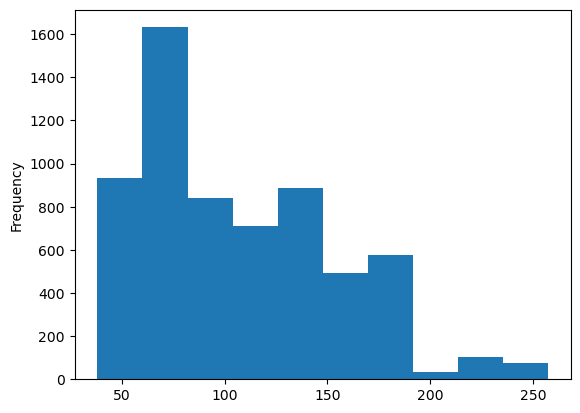

In [11]:
X['Close'].plot(kind='hist')

In [13]:
X['Close'].describe()

count    6285.000000
mean      107.473962
std        46.780141
min        37.900700
25%        65.551277
50%        94.979347
75%       139.636734
max       257.500000
Name: Close, dtype: float64

<AxesSubplot: ylabel='Frequency'>

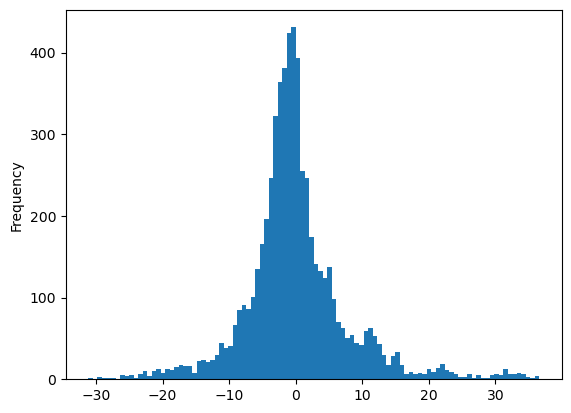

In [20]:
X['Absolute Error'].plot(kind='hist', bins=100)

<AxesSubplot: ylabel='Frequency'>

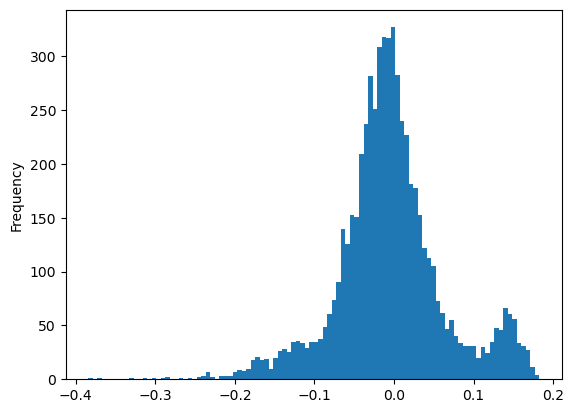

In [21]:
X['Relative Error'].plot(kind='hist', bins=100)

In [22]:
X['Relative Error'].describe()

count    6086.000000
mean       -0.005064
std         0.068205
min        -0.384187
25%        -0.038954
50%        -0.008191
75%         0.025514
max         0.182787
Name: Relative Error, dtype: float64

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Download data
# tickers = ["TLT","GLD","XLP","XLU","XLV"]
# df = yf.download(tickers, group_by='Ticker', start="2020-01-01", end="2024-12-31")

# Reshape data to create one row per date + ticker combination
# df = df.stack(level=0).rename_axis(['Date', 'Ticker'])

# Create X matrix of features and the target vector y
X = df.iloc[:, :-2]
y = df["Close"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
scaler = StandardScaler()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

0.16298555367870157